In [1]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0) 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-12 05:28:31.763654: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LAHE

training images directory

In [2]:
path1 = './IDRID/Original_Images/Training_Set'
# training masks directory
path2 = './IDRID/All_Segmentation_Groundtruths/Training_Set/Optic_Disc'
patch_size = 512

In [3]:
image_dataset = []
images = sorted(os.listdir(path1)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:10<00:00,  5.49it/s]


In [4]:
len(image_dataset)

54

In [5]:
mask_dataset = []
images = sorted(os.listdir(path2)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path2 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 54.18it/s]


In [6]:
len(mask_dataset)

54

mporting models

In [7]:
from model import unetmodel, residualunet, attentionunet
from tensorflow.keras.optimizers import Adam
from evaluation_metrics import IoU_coef,IoU_loss
import tensorflow as tf

In [8]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [9]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


def conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


def inverted_residual_block(x, expand=64, squeeze=16, dropout=0, batchnorm=False):
    m = layers.Conv2D(expand, (1, 1), activation='relu')(x)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(m)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.Conv2D(squeeze, (1, 1), activation='relu')(m)
    if dropout > 0:
        m = layers.Dropout(dropout)(m)
    if x.shape[-1] != squeeze:
        x = layers.Conv2D(squeeze, (1, 1), activation='relu')(x)
    respath = layers.add([m, x])
    return respath

# residual convolutional block


def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize),
                          kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize),
                          kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)

    # skip connection
    shortcut = layers.Conv2D(filters, kernel_size=(
        1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])
    return respath

# gating signal for attention unit


def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# attention unit/block based on soft attention


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(
        2, 2), kernel_initializer='he_normal', padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(
        inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(
        shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(
        1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(
        shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(
        x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(
        shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


def receptive_field_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    # Receptive field block
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    receptive_field = conv_block(pool, kernelsize, filters, dropout, batchnorm)
    upsampled_receptive_field = layers.UpSampling2D(
        size=(2, 2))(receptive_field)
    conv = layers.concatenate([conv, upsampled_receptive_field], axis=3)

    return conv


def unetmodel_residual(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers with receptive field blocks
    dn_1 = receptive_field_block(
        inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(dn_1)

    dn_2 = receptive_field_block(
        pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(dn_2)

    dn_3 = receptive_field_block(
        pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2, 2))(dn_3)

    dn_4 = receptive_field_block(
        pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2, 2))(dn_4)

    dn_5 = receptive_field_block(
        pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    up_5 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(dn_5)
    up_conv_5 = inverted_residual_block(
        up_5, expand=filters[3], squeeze=filters[3], dropout=dropout, batchnorm=batchnorm)
    up_5 = layers.concatenate([up_conv_5, dn_4], axis=3)
    up_5 = layers.Conv2D(filters[0], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_5)

    up_4 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_5)
    up_conv_4 = inverted_residual_block(
        up_4, expand=filters[2], squeeze=filters[2], dropout=dropout, batchnorm=batchnorm)
    up_4 = layers.concatenate([up_conv_4, dn_3], axis=3)
    up_4 = layers.Conv2D(filters[1], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_4)

    up_3 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_4)
    up_conv_3 = inverted_residual_block(
        up_3, expand=filters[1], squeeze=filters[1], dropout=dropout, batchnorm=batchnorm)
    up_3 = layers.concatenate([up_conv_3, dn_2], axis=3)
    up_3 = layers.Conv2D(filters[2], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_3)

    up_2 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_3)
    up_conv_2 = inverted_residual_block(
        up_2, expand=filters[0], squeeze=filters[0], dropout=dropout, batchnorm=batchnorm)
    up_2 = layers.concatenate([up_conv_2, dn_1], axis=3)
    up_2 = layers.Conv2D(filters[3], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_2)

    conv_final = layers.Conv2D(
        1, kernel_size=(1, 1), padding='same')(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


In [10]:
from keras import backend as K
import tensorflow as tf

defined_metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='dice_score'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='f1_score'),
]


2023-07-12 05:28:44.751425: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 05:28:45.060676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36746 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [11]:
model = unetmodel_residual(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= 'BinaryCrossentropy', metrics=defined_metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 dropout_3 (Dropout)            (None, 64, 64, 128)  0           ['activation_6[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 128)  147584      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 128)  512        ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 64, 64, 128)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooli

 batch_normalization_14 (BatchN  (None, 256, 256, 32  128        ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 depthwise_conv2d_2 (DepthwiseC  (None, 256, 256, 32  320        ['batch_normalization_14[0][0]'] 
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 256, 256, 32  128        ['depthwise_conv2d_2[0][0]']     
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  1056        ['batch_normalization_15[0][0]'] 
          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


plitting data into 70-30 ratio to validate training performance

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

rain model

In [14]:
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size=1,
                    validation_data=(x_test, y_test),
                    shuffle=False,
                    epochs=200,
                    )

Epoch 1/200


2023-07-12 05:28:48.877799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


37/37 [==============================] - 5s 52ms/step - loss: 0.6561 - auc: 0.9474 - accuracy: 0.8735 - mean_iou: 0.4909 - dice_score: 0.4909 - f1_score: 0.4909 - val_loss: 0.8103 - val_auc: 0.8425 - val_accuracy: 0.1911 - val_mean_iou: 0.4910 - val_dice_score: 0.4910 - val_f1_score: 0.4910
Epoch 2/200
 1/37 [..............................] - ETA: 0s - loss: 0.6272 - auc: 0.9959 - accuracy: 0.9757 - mean_iou: 0.4918 - dice_score: 0.4918 - f1_score: 0.4918

2023-07-12 05:28:51.092944: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 1s 19ms/step - loss: 0.6216 - auc: 0.9713 - accuracy: 0.9721 - mean_iou: 0.4913 - dice_score: 0.4913 - f1_score: 0.4913 - val_loss: 0.6282 - val_auc: 0.6629 - val_accuracy: 0.9832 - val_mean_iou: 0.4910 - val_dice_score: 0.4910 - val_f1_score: 0.4910
Epoch 3/200
37/37 [==============================] - 1s 19ms/step - loss: 0.6021 - auc: 0.9600 - accuracy: 0.9776 - mean_iou: 0.4914 - dice_score: 0.4914 - f1_score: 0.4914 - val_loss: 0.6032 - val_auc: 0.2990 - val_accuracy: 0.9820 - val_mean_iou: 0.4910 - val_dice_score: 0.4910 - val_f1_score: 0.4910
Epoch 4/200
37/37 [==============================] - 1s 19ms/step - loss: 0.5820 - auc: 0.9745 - accuracy: 0.9817 - mean_iou: 0.4915 - dice_score: 0.4915 - f1_score: 0.4915 - val_loss: 0.5501 - val_auc: 0.9455 - val_accuracy: 0.9848 - val_mean_iou: 0.4910 - val_dice_score: 0.4910 - val_f1_score: 0.4910
Epoch 5/200
37/37 [==============================] - 1s 19ms/step - loss: 0.5659 - auc: 0.9750 - acc

Epoch 29/200
37/37 [==============================] - 1s 20ms/step - loss: 0.2788 - auc: 0.9984 - accuracy: 0.9974 - mean_iou: 0.5431 - dice_score: 0.5431 - f1_score: 0.5431 - val_loss: 0.2883 - val_auc: 0.6651 - val_accuracy: 0.9861 - val_mean_iou: 0.4919 - val_dice_score: 0.4919 - val_f1_score: 0.4919
Epoch 30/200
37/37 [==============================] - 1s 20ms/step - loss: 0.2718 - auc: 0.9990 - accuracy: 0.9976 - mean_iou: 0.5511 - dice_score: 0.5511 - f1_score: 0.5511 - val_loss: 0.2826 - val_auc: 0.7157 - val_accuracy: 0.9862 - val_mean_iou: 0.4942 - val_dice_score: 0.4942 - val_f1_score: 0.4942
Epoch 31/200
37/37 [==============================] - 1s 19ms/step - loss: 0.2723 - auc: 0.9924 - accuracy: 0.9956 - mean_iou: 0.5672 - dice_score: 0.5672 - f1_score: 0.5672 - val_loss: 0.2801 - val_auc: 0.9140 - val_accuracy: 0.9870 - val_mean_iou: 0.5126 - val_dice_score: 0.5126 - val_f1_score: 0.5126
Epoch 32/200
37/37 [==============================] - 1s 20ms/step - loss: 0.2792 - a

Epoch 56/200
37/37 [==============================] - 1s 20ms/step - loss: 0.1450 - auc: 0.9992 - accuracy: 0.9981 - mean_iou: 0.7554 - dice_score: 0.7554 - f1_score: 0.7554 - val_loss: 0.1654 - val_auc: 0.6932 - val_accuracy: 0.9876 - val_mean_iou: 0.5528 - val_dice_score: 0.5528 - val_f1_score: 0.5528
Epoch 57/200
37/37 [==============================] - 1s 21ms/step - loss: 0.1421 - auc: 0.9988 - accuracy: 0.9980 - mean_iou: 0.7653 - dice_score: 0.7653 - f1_score: 0.7653 - val_loss: 0.1613 - val_auc: 0.7028 - val_accuracy: 0.9872 - val_mean_iou: 0.5105 - val_dice_score: 0.5105 - val_f1_score: 0.5105
Epoch 58/200
37/37 [==============================] - 1s 20ms/step - loss: 0.1385 - auc: 0.9989 - accuracy: 0.9982 - mean_iou: 0.7706 - dice_score: 0.7706 - f1_score: 0.7706 - val_loss: 0.1612 - val_auc: 0.6288 - val_accuracy: 0.9868 - val_mean_iou: 0.5525 - val_dice_score: 0.5525 - val_f1_score: 0.5525
Epoch 59/200
37/37 [==============================] - 1s 20ms/step - loss: 0.1350 - a

Epoch 83/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0820 - auc: 0.9997 - accuracy: 0.9987 - mean_iou: 0.8663 - dice_score: 0.8663 - f1_score: 0.8663 - val_loss: 0.1202 - val_auc: 0.6214 - val_accuracy: 0.9832 - val_mean_iou: 0.4910 - val_dice_score: 0.4910 - val_f1_score: 0.4910
Epoch 84/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0808 - auc: 0.9998 - accuracy: 0.9986 - mean_iou: 0.8724 - dice_score: 0.8724 - f1_score: 0.8724 - val_loss: 0.1187 - val_auc: 0.6103 - val_accuracy: 0.9835 - val_mean_iou: 0.4951 - val_dice_score: 0.4951 - val_f1_score: 0.4951
Epoch 85/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0789 - auc: 0.9997 - accuracy: 0.9987 - mean_iou: 0.8765 - dice_score: 0.8765 - f1_score: 0.8765 - val_loss: 0.1174 - val_auc: 0.5981 - val_accuracy: 0.9833 - val_mean_iou: 0.4999 - val_dice_score: 0.4999 - val_f1_score: 0.4999
Epoch 86/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0779 - a

Epoch 110/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0497 - auc: 0.9999 - accuracy: 0.9988 - mean_iou: 0.9057 - dice_score: 0.9057 - f1_score: 0.9057 - val_loss: 0.0878 - val_auc: 0.6967 - val_accuracy: 0.9856 - val_mean_iou: 0.5462 - val_dice_score: 0.5462 - val_f1_score: 0.5462
Epoch 111/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0492 - auc: 0.9995 - accuracy: 0.9987 - mean_iou: 0.9049 - dice_score: 0.9049 - f1_score: 0.9049 - val_loss: 0.0856 - val_auc: 0.6637 - val_accuracy: 0.9866 - val_mean_iou: 0.5752 - val_dice_score: 0.5752 - val_f1_score: 0.5752
Epoch 112/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0484 - auc: 0.9998 - accuracy: 0.9987 - mean_iou: 0.8943 - dice_score: 0.8943 - f1_score: 0.8943 - val_loss: 0.0854 - val_auc: 0.7314 - val_accuracy: 0.9860 - val_mean_iou: 0.5566 - val_dice_score: 0.5566 - val_f1_score: 0.5566
Epoch 113/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0481

Epoch 137/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0315 - auc: 0.9998 - accuracy: 0.9989 - mean_iou: 0.9023 - dice_score: 0.9023 - f1_score: 0.9023 - val_loss: 0.0860 - val_auc: 0.5833 - val_accuracy: 0.9834 - val_mean_iou: 0.5086 - val_dice_score: 0.5086 - val_f1_score: 0.5086
Epoch 138/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0311 - auc: 0.9997 - accuracy: 0.9989 - mean_iou: 0.9080 - dice_score: 0.9080 - f1_score: 0.9080 - val_loss: 0.0853 - val_auc: 0.6015 - val_accuracy: 0.9835 - val_mean_iou: 0.5091 - val_dice_score: 0.5091 - val_f1_score: 0.5091
Epoch 139/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0309 - auc: 0.9999 - accuracy: 0.9988 - mean_iou: 0.9076 - dice_score: 0.9076 - f1_score: 0.9076 - val_loss: 0.0842 - val_auc: 0.6218 - val_accuracy: 0.9838 - val_mean_iou: 0.5131 - val_dice_score: 0.5131 - val_f1_score: 0.5131
Epoch 140/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0300

Epoch 164/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0210 - auc: 0.9999 - accuracy: 0.9988 - mean_iou: 0.9050 - dice_score: 0.9050 - f1_score: 0.9050 - val_loss: 0.0828 - val_auc: 0.6202 - val_accuracy: 0.9831 - val_mean_iou: 0.5038 - val_dice_score: 0.5038 - val_f1_score: 0.5038
Epoch 165/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0203 - auc: 0.9999 - accuracy: 0.9990 - mean_iou: 0.9064 - dice_score: 0.9064 - f1_score: 0.9064 - val_loss: 0.0843 - val_auc: 0.5797 - val_accuracy: 0.9829 - val_mean_iou: 0.4972 - val_dice_score: 0.4972 - val_f1_score: 0.4972
Epoch 166/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0199 - auc: 1.0000 - accuracy: 0.9990 - mean_iou: 0.9068 - dice_score: 0.9068 - f1_score: 0.9068 - val_loss: 0.0820 - val_auc: 0.5987 - val_accuracy: 0.9833 - val_mean_iou: 0.5019 - val_dice_score: 0.5019 - val_f1_score: 0.5019
Epoch 167/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0197

Epoch 191/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0137 - auc: 1.0000 - accuracy: 0.9991 - mean_iou: 0.9165 - dice_score: 0.9165 - f1_score: 0.9165 - val_loss: 0.0845 - val_auc: 0.5628 - val_accuracy: 0.9832 - val_mean_iou: 0.5047 - val_dice_score: 0.5047 - val_f1_score: 0.5047
Epoch 192/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0136 - auc: 1.0000 - accuracy: 0.9991 - mean_iou: 0.9133 - dice_score: 0.9133 - f1_score: 0.9133 - val_loss: 0.0848 - val_auc: 0.5574 - val_accuracy: 0.9831 - val_mean_iou: 0.4971 - val_dice_score: 0.4971 - val_f1_score: 0.4971
Epoch 193/200
37/37 [==============================] - 1s 21ms/step - loss: 0.0133 - auc: 0.9999 - accuracy: 0.9992 - mean_iou: 0.9197 - dice_score: 0.9197 - f1_score: 0.9197 - val_loss: 0.0879 - val_auc: 0.5402 - val_accuracy: 0.9826 - val_mean_iou: 0.4933 - val_dice_score: 0.4933 - val_f1_score: 0.4933
Epoch 194/200
37/37 [==============================] - 1s 20ms/step - loss: 0.0139

raining-validation loss curve

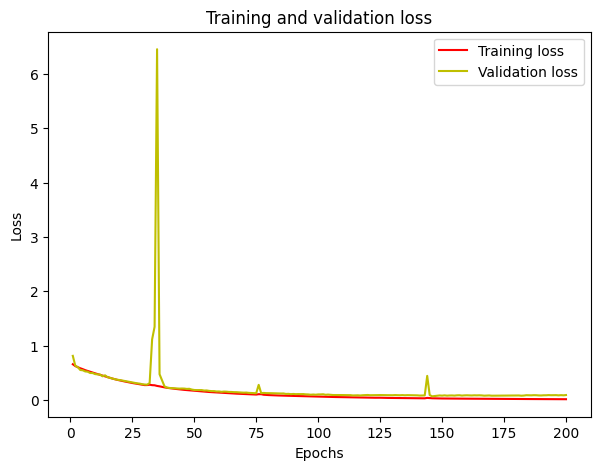

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

raining-validation accuracy curve

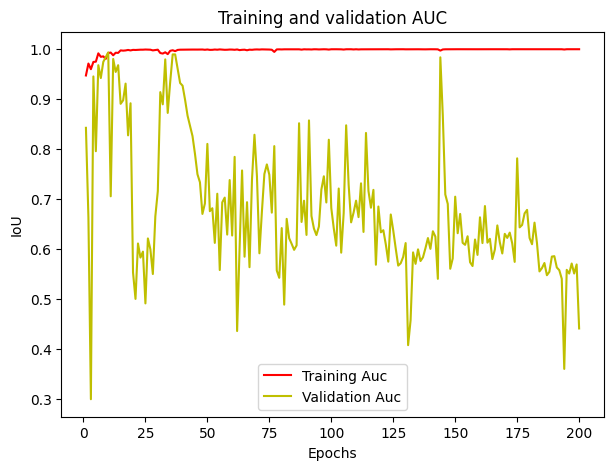

In [16]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure(figsize=(7,5))
plt.plot(epochs, auc, 'r', label='Training Auc')
plt.plot(epochs, val_auc, 'y', label='Validation Auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

raining-validation IoU curve

In [17]:
model.save('./OD_models/optic_disc_attentionunet_ive.h5')

In [29]:
model = tf.keras.models.load_model('./best models/optic_disc_attentionunet_ive.h5')

In [30]:
# test dataset images directory path
path3 = './IDRID/Original_Images/Testing_Set'
# test dataset mask directory path
path4 = './IDRID/All_Segmentation_Groundtruths/Testing_Set/Optic_Disc'

In [31]:
testimages = sorted(os.listdir(path3))
testmasks =  sorted(os.listdir(path4))

In [32]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0)

image_dataset = []
images = sorted(os.listdir(path3)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path3+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.93it/s]


In [33]:
mask_dataset = []
images = sorted(os.listdir(path4)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path4 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
test_image_dataset = np.expand_dims(image_dataset,axis=-1)
test_mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 47.35it/s]


In [34]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_image_dataset, test_mask_dataset, batch_size=1)
print("test loss, test auc:", results)

# # Generate predictions (probabilities -- the output of the last layer)
# # on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_image_dataset[:1])
print("predictions shape:", predictions.shape)

Evaluate on test data
27/27 [==============================] - 1s 8ms/step - loss: 0.1456 - auc: 0.8877
test loss, test auc: [0.14563113451004028, 0.8876926898956299]
Generate predictions for 3 samples
1/1 [==============================] - 1s 646ms/step
predictions shape: (1, 512, 512, 1)


In [35]:
val_pred = model.predict(test_image_dataset, batch_size=1)

27/27 [==============================] - 0s 5ms/step


In [36]:
val_pred  

array([[[[0.1045575 ],
         [0.1042901 ],
         [0.10425166],
         ...,
         [0.10457513],
         [0.10453311],
         [0.10475285]],

        [[0.10470777],
         [0.104708  ],
         [0.10470834],
         ...,
         [0.10471948],
         [0.10468086],
         [0.10457239]],

        [[0.10472137],
         [0.10472196],
         [0.1047232 ],
         ...,
         [0.10471442],
         [0.10468172],
         [0.10459365]],

        ...,

        [[0.10509143],
         [0.10507407],
         [0.10503969],
         ...,
         [0.10381078],
         [0.10380609],
         [0.10365362]],

        [[0.10508677],
         [0.1050693 ],
         [0.10503413],
         ...,
         [0.10380433],
         [0.1037998 ],
         [0.10366771]],

        [[0.10491256],
         [0.10506677],
         [0.10503139],
         ...,
         [0.10380115],
         [0.10379669],
         [0.10364126]]],


       [[[0.10455554],
         [0.10430264],
         [0.10

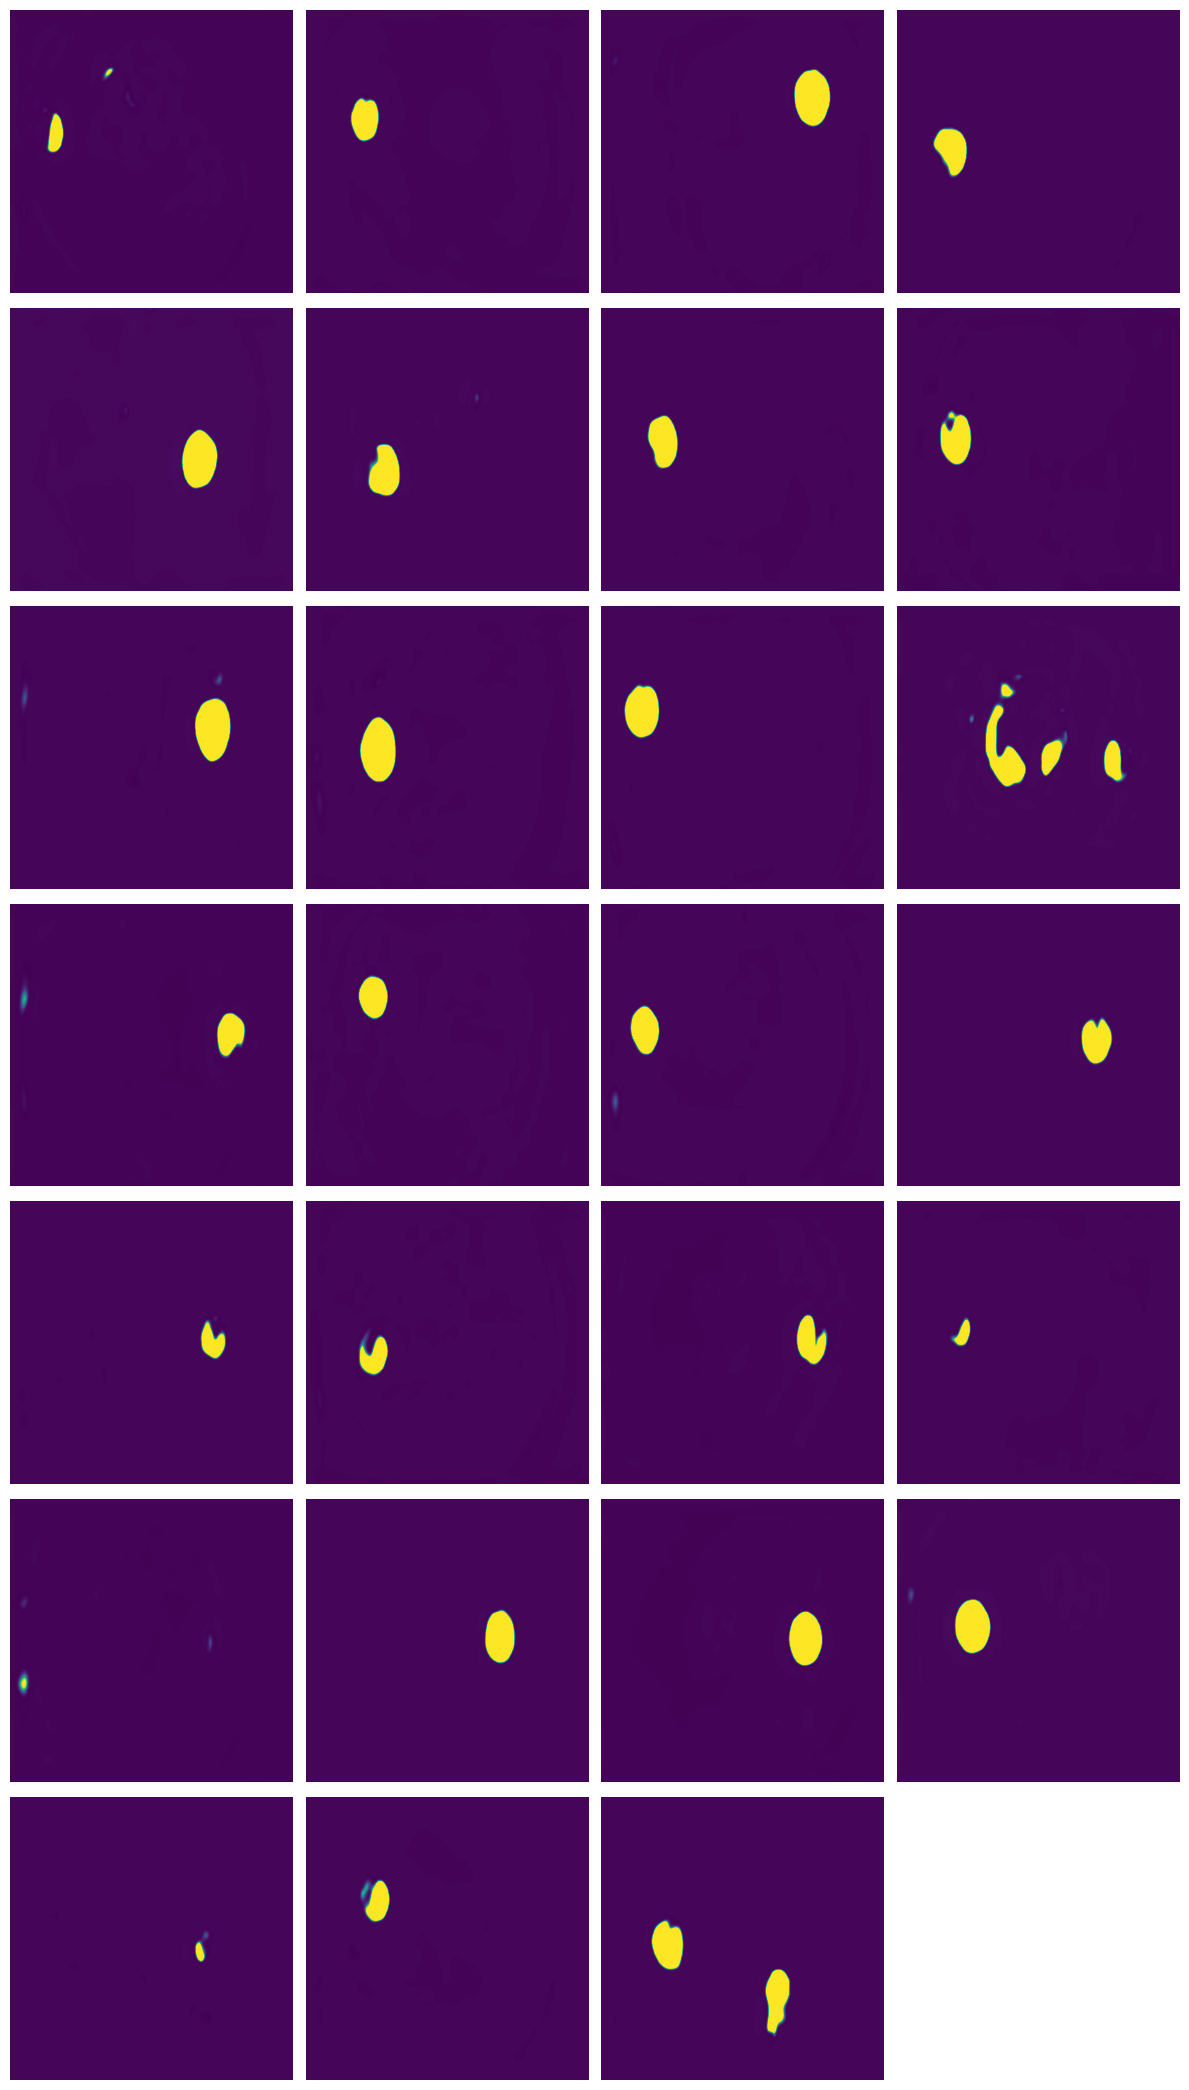

In [37]:
import matplotlib.pyplot as plt

# Assuming val_pred is a NumPy array containing the predicted images

num_images = val_pred.shape[0]  # Get the number of predicted images

# Create a grid of subplots to display the images
rows = int(num_images / 4) + 1
fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))

# Iterate over the predicted images and plot them
for i in range(num_images):
    ax = axes[i // 4, i % 4]
    ax.imshow(val_pred[i])
    ax.axis('off')

# Remove any empty subplots if the number of images is not a multiple of 4
if num_images % 4 != 0:
    for i in range(num_images % 4, 4):
        axes[-1, i].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [38]:
for i in range (val_pred.shape[0]) :
    print(i,np.sum(val_pred[i,:,:,:]))

0 28819.557
1 29958.959
2 32053.475
3 30486.994
4 32008.676
5 30909.365
6 30816.766
7 30924.648
8 32507.016
9 32555.504
10 31640.975
11 35394.816
12 30063.238
13 30208.223
14 30420.574
15 30383.834
16 29088.777
17 29493.98
18 30183.012
19 28161.742
20 27648.83
21 30982.082
22 31461.744
23 31711.707
24 27856.293
25 29416.324
26 33978.37
